In [ ]:
from pandas.core.common import flatten
import time
import sys
import os
import numpy as np
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_peptide_bonds
from functools import partial
#from graphein.protein.visualisation import plotly_protein_structure_graph

from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_k_nn_edges,
                                             add_distance_threshold,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions,
                                             add_delaunay_triangulation
                                            )

from graphein.protein.features.nodes import secondary_structure
from graphein.protein.subgraphs import extract_subgraph_from_secondary_structure
from graphein.protein.config import DSSPConfig
from graphein.protein.subgraphs import extract_surface_subgraph
from graphein.protein.features.nodes import rsa
import networkx as nx                                       
import logging
import matplotlib.pyplot as plt
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("graphein").setLevel(logging.INFO)
import graphein.protein as gp
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status

In [ ]:
!pip install graphein

In [3]:
import zipfile

azip = zipfile.ZipFile('PDB.zip') 

azip.extractall()

In [4]:
# define different graph
def edge_f(a,b):
  edge_funcs1 = {"edge_construction_functions": [partial(add_distance_threshold, long_interaction_threshold=a, threshold=b),
                                                  add_aromatic_interactions,
                                                  add_hydrogen_bond_interactions,
                                                  add_disulfide_interactions,
                                                  add_ionic_interactions,
                                                  add_aromatic_sulphur_interactions,
                                                  add_cation_pi_interactions
                                                   ]
                 }




  edge_funcs2 = {"edge_construction_functions": [
                                                 add_aromatic_interactions,
                                                 add_hydrogen_bond_interactions,
                                                 add_disulfide_interactions,
                                                 add_ionic_interactions,
                                                 add_aromatic_sulphur_interactions,
                                                 add_cation_pi_interactions
                                                   ]
                 }

  edge_funcs3 = {"edge_construction_functions": [partial(add_distance_threshold, long_interaction_threshold=a, threshold=b)
                                                  
                                                   ]
                 }

  edge_funcs4 = {"edge_construction_functions": [add_delaunay_triangulation        
                                                   ]
                 }

  edge_funcs5 = {"edge_construction_functions": [partial(add_k_nn_edges, k=3, long_interaction_threshold=0)]
                 }
   
  edge_funcs = [edge_funcs1,edge_funcs2,edge_funcs3,edge_funcs4,edge_funcs5]
  
  return edge_funcs

In [5]:
import networkx as nx
from graphein.protein.graphs import construct_graph
from graphein.protein.subgraphs import extract_subgraph


#data load
GH16 = ['A0A7Z9D2A7','A5FC91','D9TGW6','E4N879','G8JN03','Q21N15','Q47XT7']
GH27 = ['A0A385TLX0','A0A3G3K5N5','A0A4P7NIG7','A0A6B8RPE7','A0A6M4XDE9','A0A8X8LEQ7']
GH30 = ['A0A3G2G2Q1','A0A6I5ZWY8','A0A7G8UJ47','A0A7U4Z621','H6NC90','Q09DH4']
GH35 = ['A0A0H3D6J3','A0A223HUM7','A0A4Y1V9N2','A0A7H5K301','F0VA11']


pdb_p_GH30 = "/content/PDB/Q09DH4/Q09DH4.pdb"
pdb_p_GH35 = "/content/PDB/C3VDH8/C3VDH8.pdb"
pdb_p_GH16 = "/content/PDB/Q21N15/Q21N15.pdb"
pdb_p_GH27 = "/content/PDB/A0A6M4XDE9/A0A6M4XDE9.pdb"

def nodes_list(g,s,e):
    nodes =[]
    for i in g.nodes:
        nodes.append(i)
    return nodes[s-1:e] 

def get_network(s_g):
    nodes = []
    for i in s_g.nodes:
        nodes.append(i)
    
    edges = [] 
    for j in s_g.edges:
        edges.append(j)
    G = nx.Graph()
    
    for node in nodes:
        G.add_node(node)

    for link in edges:
        G.add_edge(link[0], link[1])
    return G

def sub_graph(edge_func):
    config = ProteinGraphConfig(**edge_func)

    g1 = construct_graph(config=config, path=pdb_p_GH30)
    g2 = construct_graph(config=config, path=pdb_p_GH35)
    g3 = construct_graph(config=config, path=pdb_p_GH16)
    g4 = construct_graph(config=config, path=pdb_p_GH27)

    s_g1 = extract_subgraph(g1, node_list=nodes_list(g1,33,478), inverse=False)
    s_g2 = extract_subgraph(g2, node_list=nodes_list(g2,20,408), inverse=False)
    s_g3 = extract_subgraph(g3, node_list=nodes_list(g3,328,567), inverse=False)
    s_g4 = extract_subgraph(g4, node_list=nodes_list(g4,48,380), inverse=False)
    
    G1 = get_network(s_g1)
    G2 = get_network(s_g2)
    G3 = get_network(s_g3)
    G4 = get_network(s_g4)
    
    return G1,G2,G3,G4
#s_g1,s_g2,s_g3,s_g4

In [ ]:
def get_ratio(edge_funcs):
  avg_degrees_all = []
  avg_ccs_all = []

  for i in range(3):
      G1,G2,G3,G4 = sub_graph(edge_funcs[i])
      G = [G1,G2,G3,G4]
      avg_degrees = []
      avg_ccs = []
      for j in range(len(G)):
          degrees = dict(G[j].degree())
          

          avg_degree = sum(degrees.values()) / len(degrees)
          avg_cc = nx.average_clustering(G[j])
      
          avg_degrees.append(avg_degree)
          avg_ccs.append(avg_cc )
      avg_degrees_all.append(avg_degrees)
      avg_ccs_all.append(avg_ccs)
  index_outcon_de=[]
  index_incon_de=[]
  for i in range(3):
      if abs(avg_degrees_all[i][3]-avg_degrees_all[i][0]) ==0:
          index_outcon_de.append('NA')
      if abs(avg_degrees_all[i][1]-avg_degrees_all[i][0]) == 0:  
          index_incon_de.append('NA')
      else:
          index_outcon_de.append(abs(avg_degrees_all[i][2]-avg_degrees_all[i][0])/abs(avg_degrees_all[i][3]-avg_degrees_all[i][0]))
          index_incon_de.append(abs(avg_degrees_all[i][3]-avg_degrees_all[i][0])/abs(avg_degrees_all[i][1]-avg_degrees_all[i][0]))

  index_outcon=[]
  index_incon=[]
  for i in range(3):
      if abs(avg_ccs_all[i][3]-avg_ccs_all[i][0]) ==0:
          index_outcon.append('NA')
      if abs(avg_ccs_all[i][1]-avg_ccs_all[i][0]) == 0:  
          index_incon.append('NA')
      else:

          index_outcon.append(abs(avg_ccs_all[i][2]-avg_ccs_all[i][0])/abs(avg_ccs_all[i][3]-avg_ccs_all[i][0]))
          index_incon.append(abs(avg_ccs_all[i][3]-avg_ccs_all[i][0])/abs(avg_ccs_all[i][1]-avg_ccs_all[i][0]))

  return index_outcon,index_incon,index_outcon_de,index_incon_de 




In [ ]:
index_outconss={}
index_inconss={}
index_outcon_dess={}
index_incon_dess={}
for a in range(10):
    index_outcons=[]
    index_incons=[]
    index_outcon_des=[]
    index_incon_des=[]
    for b in range(10):
        edge_funcs = edge_f(a,b+3)
        index_outcon,index_incon,index_outcon_de,index_incon_de = get_ratio(edge_funcs)
        index_outcons.append(index_outcon)
        index_incons.append(index_incon)
        index_outcon_des.append(index_outcon_de)
        index_incon_des.append(index_incon_de)

    index_outconss[a]=index_outcons
    index_inconss[a]=index_incons
    index_outcon_dess[a]=index_outcon_des
    index_incon_dess[a]=index_incon_des

<ipython-input-9-ca4b34dc637c>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data1=x1.reshape(10,10).astype(np.float)
<ipython-input-9-ca4b34dc637c>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data2=x2.reshape(10,10).astype(np.float)
<ipython-input-9-ca4b34dc637c>:17: DeprecationWarning: `np.float` is a deprecated alias for the 

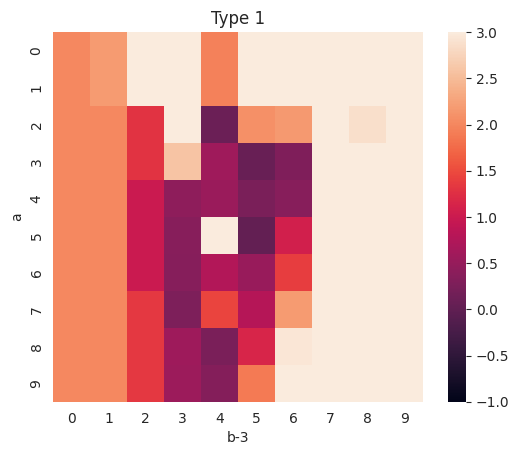

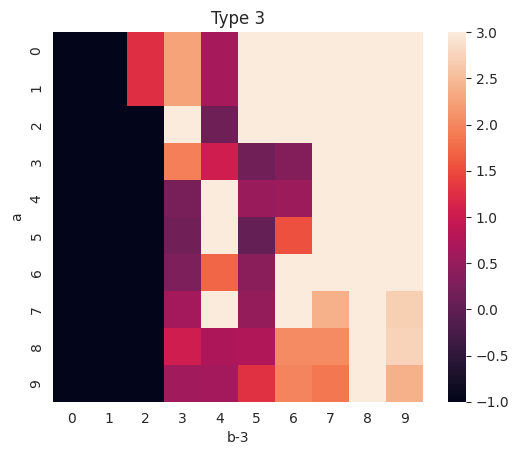

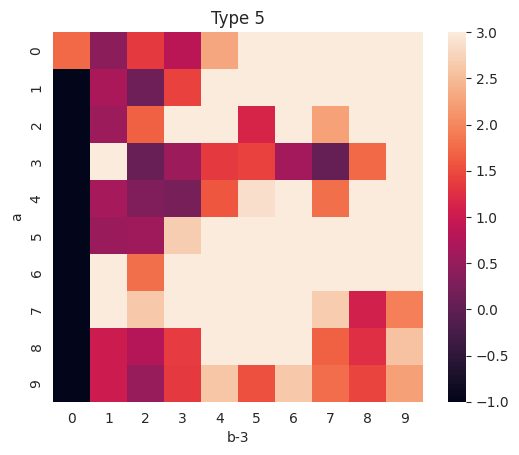

In [ ]:
import seaborn as sns
dataIndex1=[]
for i in range(10):
  for j in range(10):
      raw = [int(i),int(j+5),float(index_outconss[i][j][0]),index_outconss[i][j][1],index_outconss[i][j][2]]
      dataIndex1.append(raw)
a=np.array(dataIndex1)[:,0]
b=np.array(dataIndex1)[:,1]
x1=np.array(dataIndex1)[:,2]
x2=np.array(dataIndex1)[:,3]
x3=np.array(dataIndex1)[:,4]   

data1=x1.reshape(10,10).astype(np.float)
x2[x2=='NA']=-1
data2=x2.reshape(10,10).astype(np.float)
x3[x3=='NA']=-1
data3=x3.reshape(10,10).astype(np.float)

mask = np.zeros_like(data1)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data1, vmin=-1, vmax=3,square=True)
plt.title('Type 1') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data2,  vmin=-1, vmax=3,square=True)
plt.title('Type 3') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data3)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data3,  vmin=-1, vmax=3,square=True)
plt.title('Type 5') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

<ipython-input-10-ba9e76dc8272>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data1=x1.reshape(10,10).astype(np.float)
<ipython-input-10-ba9e76dc8272>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data2=x2.reshape(10,10).astype(np.float)
<ipython-input-10-ba9e76dc8272>:17: DeprecationWarning: `np.float` is a deprecated alias for t

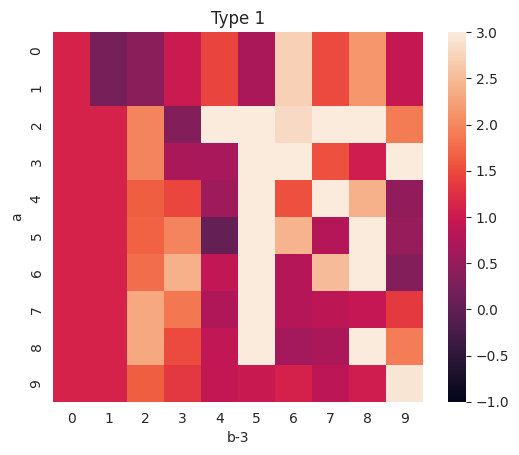

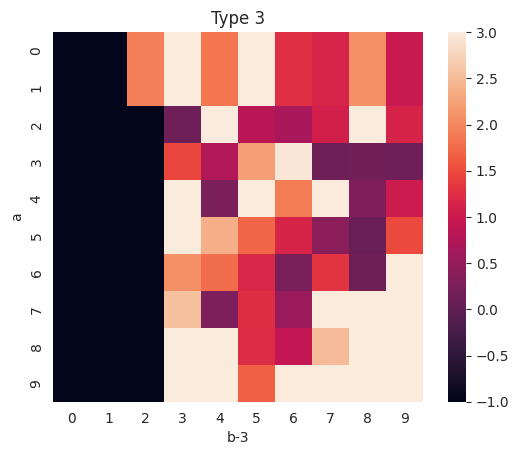

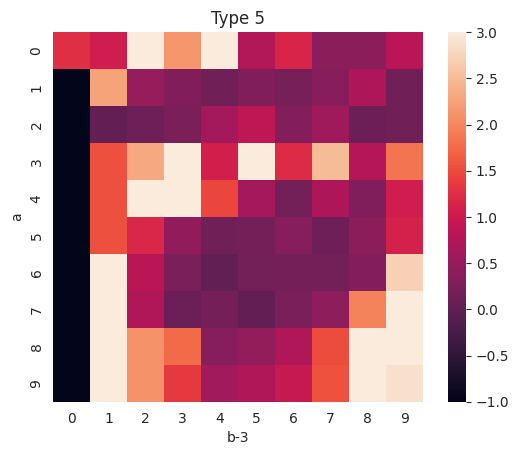

In [ ]:

import seaborn as sns
dataIndex1=[]
for i in range(10):
  for j in range(10):
      raw = [int(i),int(j+5),float(index_inconss[i][j][0]),index_inconss[i][j][1],index_inconss[i][j][2]]
      dataIndex1.append(raw)
a=np.array(dataIndex1)[:,0]
b=np.array(dataIndex1)[:,1]
x1=np.array(dataIndex1)[:,2]
x2=np.array(dataIndex1)[:,3]
x3=np.array(dataIndex1)[:,4]   

data1=x1.reshape(10,10).astype(np.float)
x2[x2=='NA']=-1
data2=x2.reshape(10,10).astype(np.float)
x3[x3=='NA']=-1
data3=x3.reshape(10,10).astype(np.float)

mask = np.zeros_like(data1)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data1,  vmin=-1, vmax=3,square=True)
plt.title('Type 1') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data2, vmin=-1, vmax=3,square=True)
plt.title('Type 3') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data3)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data3,  vmin=-1, vmax=3,square=True)
plt.title('Type 5') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

<ipython-input-11-c5e59f2e6db7>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data1=x1.reshape(10,10).astype(np.float)
<ipython-input-11-c5e59f2e6db7>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data2=x2.reshape(10,10).astype(np.float)
<ipython-input-11-c5e59f2e6db7>:17: DeprecationWarning: `np.float` is a deprecated alias for t

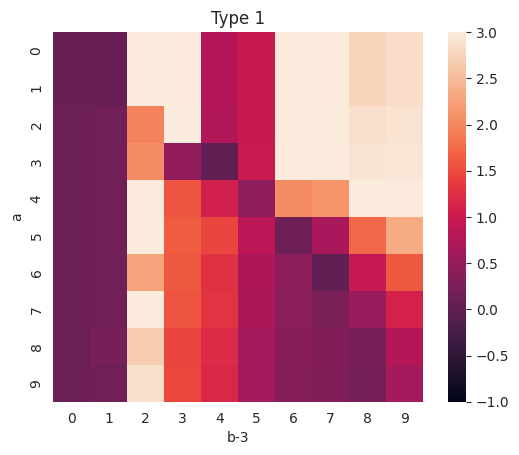

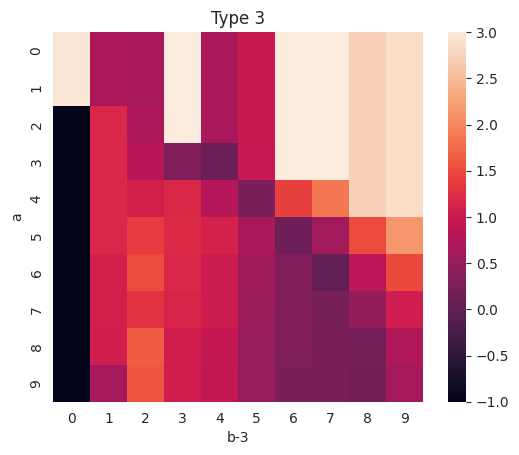

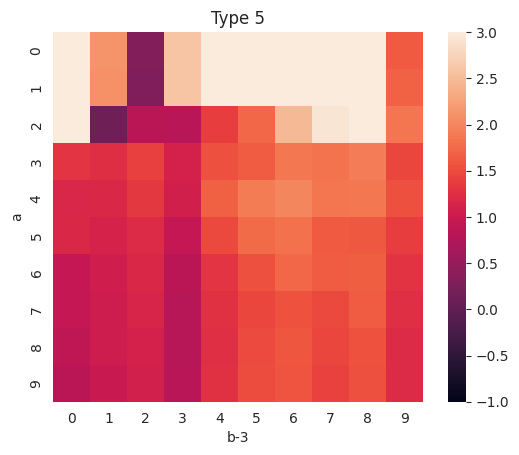

In [ ]:
import seaborn as sns
dataIndex1=[]
for i in range(10):
  for j in range(10):
      raw = [int(i),int(j+5),float(index_outcon_dess[i][j][0]),index_outcon_dess[i][j][1],index_outcon_dess[i][j][2]]
      dataIndex1.append(raw)
a=np.array(dataIndex1)[:,0]
b=np.array(dataIndex1)[:,1]
x1=np.array(dataIndex1)[:,2]
x2=np.array(dataIndex1)[:,3]
x3=np.array(dataIndex1)[:,4]   

data1=x1.reshape(10,10).astype(np.float)
x2[x2=='NA']=-1
data2=x2.reshape(10,10).astype(np.float)
x3[x3=='NA']=-1
data3=x3.reshape(10,10).astype(np.float)

mask = np.zeros_like(data1)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data1, vmin=-1, vmax=3,square=True)
plt.title('Type 1') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data2,  vmin=-1, vmax=3,square=True)
plt.title('Type 3') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data3)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data3, vmin=-1, vmax=3,square=True)
plt.title('Type 5') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

<ipython-input-12-94102ecc8ed8>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data1=x1.reshape(10,10).astype(np.float)
<ipython-input-12-94102ecc8ed8>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data2=x2.reshape(10,10).astype(np.float)
<ipython-input-12-94102ecc8ed8>:17: DeprecationWarning: `np.float` is a deprecated alias for t

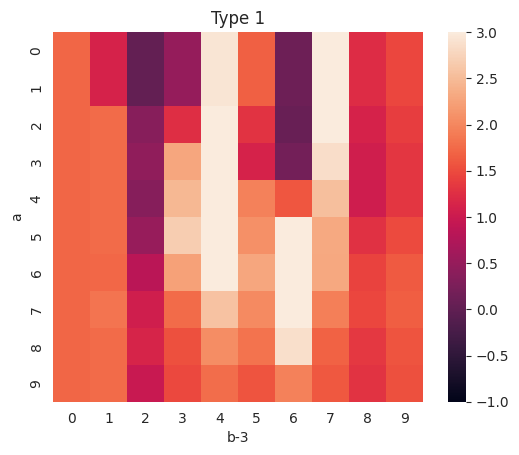

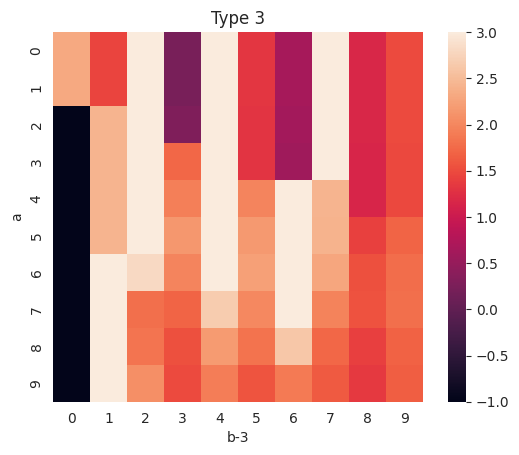

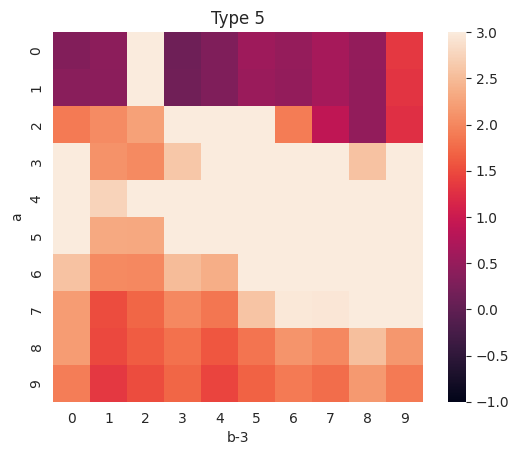

In [ ]:
import seaborn as sns
dataIndex1=[]
for i in range(10):
  for j in range(10):
      raw = [int(i),int(j+5),float(index_incon_dess[i][j][0]),index_incon_dess[i][j][1],index_incon_dess[i][j][2]]
      dataIndex1.append(raw)
a=np.array(dataIndex1)[:,0]
b=np.array(dataIndex1)[:,1]
x1=np.array(dataIndex1)[:,2]
x2=np.array(dataIndex1)[:,3]
x3=np.array(dataIndex1)[:,4]   

data1=x1.reshape(10,10).astype(np.float)
x2[x2=='NA']=-1
data2=x2.reshape(10,10).astype(np.float)
x3[x3=='NA']=-1
data3=x3.reshape(10,10).astype(np.float)

mask = np.zeros_like(data1)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data1,  vmin=-1, vmax=3,square=True)
plt.title('Type 1') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data2,  vmin=-1, vmax=3,square=True)
plt.title('Type 3') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()

mask = np.zeros_like(data3)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(data3,  vmin=-1, vmax=3,square=True)
plt.title('Type 5') # title with fontsize 20
plt.xlabel('b-3') # x-axis label with fontsize 15
plt.ylabel('a') # y-axis label with fontsize 15
plt.show()